Na přednášce jsme si ukazovali genetické programování. Dneska si ho vyzkoušíme na cvičení na problému symbolické regrese (tj. nalezení vzorečku, který odpovídá zadaným datům) a klasifikace, tj. hledání rozhodovacího stromu pomocí genetického programování. Budeme používat knihovnu `deap`, kterou jsme si stručně ukázali minule.

Začneme importy a vygenerujeme si data, která pro regresi použijeme.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.plot(x_train, y_train)
plt.show()

Připravíme si ještě pomocnou funkci na zobrazení vytvořeného stromu. Ta používa knihovnu pydot (a program GraphViz) pro kreslení grafů.

In [2]:
import pydot
from IPython.display import Image

#zobrazeni jedince jako stromu
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

Při práci s genetickým programováním potřebujeme vytvořit množinu primitiv - terminálů a neterminálů, se kterými bude evoluce pracovat. Na to je v `deap` třída `gp.PrimitiveSet`, nebo `gp.PrimitiveSetTyped` pro typované GP. Ukážeme si tu typovaný případ, protože je obecnější. Budeme ale používat pouze jeden typ, takže vlastně není potřeba.

In [3]:
import operator

from deap import gp

pset = gp.PrimitiveSetTyped('MAIN', [float], float) # mnozina se jmenuje MAIN, vstup je jeden float, vystup je float
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

In [4]:
from deap import creator, base, tools, algorithms

#definujeme fitness - pocita MSE a velikost jedince, vahy jsou nastavene nize (-1.0 a -0.01)
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # vytvorime funkci, ktera pocita jedince
    vals = list(map(func, x))
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#nastavime algoritmus
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#limity na hloubku stromu
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [5]:
pop = toolbox.population(n=1000)
#ulozeni nejlepsiho jedince
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	            fitness            	              size             
   	      	-------------------------------	-------------------------------
gen	nevals	avg    	max   	min    	std    	avg   	max	min	std    
0  	1000  	346.547	121345	10.1149	4009.98	61.291	745	4  	106.841
1  	566   	110.825	1548.23	7.46224	49.1475	41.153	617	2  	74.8011
2  	540   	100.704	880.087	10.1149	38.0759	28.316	584	2  	44.7339
3  	556   	88.9403	590.145	9.97719	42.3008	22.309	266	2  	20.9455
4  	555   	74.5183	1936.94	7.03293	74.2753	22.133	82 	3  	10.2146
5  	541   	61.1557	2076.01	7.03293	88.9923	23.612	80 	3  	10.8261
6  	523   	68.5488	16798.2	7.03293	542.713	24.942	79 	2  	11.0568
7  	528   	43.7216	1958.44	7.03152	108.602	27.264	79 	3  	10.8863
8  	549   	54.9796	9097.87	7.03152	324.193	27.056	77 	3  	10.3958
9  	575   	39.1341	1943.65	7.03152	111.604	25.232	65 	3  	10.2815
10 	577   	38.2727	1467.76	7.03152	91.7778	24.835	65 	2  	10.703 
11 	584   	46.8462	2690.78	7.03152	181.082	23.803	79 	3  	10

Zobrazíme nejlepšího jedince na konci evoluce.

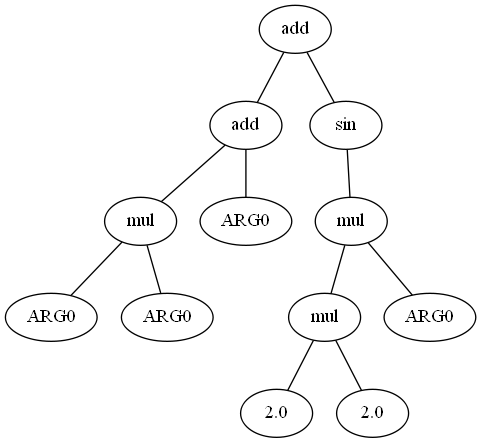

In [6]:
Image(plot_tree(hof[0]))

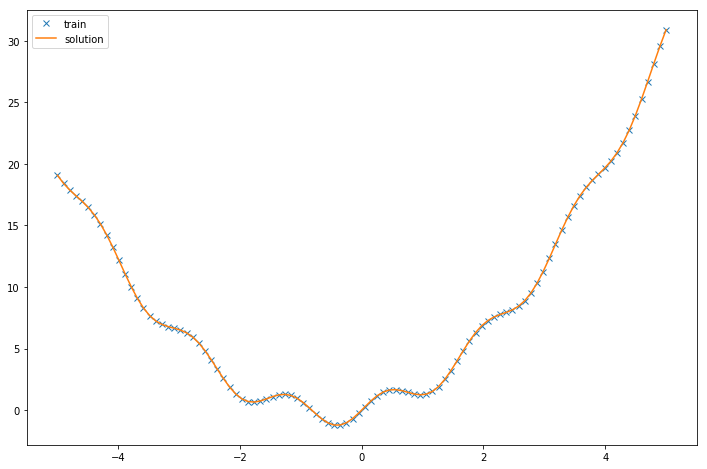

In [7]:
# porovname naucenou funkci s trenovacimi daty
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'x', label='train')
plt.plot(x_train, y, label='solution')
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace, např. pro dataset s irisy. Promyslete si, jak definovat množinu primitiv a fitness. Implementujte je a spusttě genetické programování.